In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import scipy.stats as stt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%pylab inline

In [2]:
data = pd.read_csv('Data/heart.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
age         1025 non-null int64
sex         1025 non-null int64
cp          1025 non-null int64
trestbps    1025 non-null int64
chol        1025 non-null int64
fbs         1025 non-null int64
restecg     1025 non-null int64
thalach     1025 non-null int64
exang       1025 non-null int64
oldpeak     1025 non-null float64
slope       1025 non-null int64
ca          1025 non-null int64
thal        1025 non-null int64
target      1025 non-null int64
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


age  
sex  
chest pain type (4 values)  
resting blood pressure
serum cholestoral in mg/dl  
fasting blood sugar > 120 mg/dl  
resting electrocardiographic results (values 0,1,2)  
maximum heart rate achieved  
exercise induced angina  
oldpeak = ST depression induced by exercise relative to rest  
the slope of the peak exercise ST segment  
number of major vessels (0-3) colored by flourosopy  
thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

In [4]:
print(data.shape)
data.head()

(1025, 14)


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

Age histogram show rather bimodal behavior than normal.

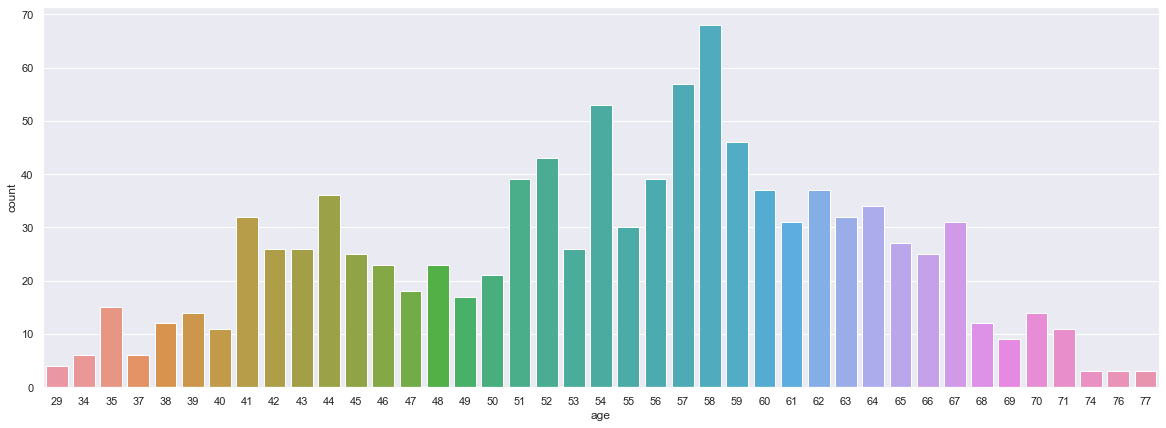

In [5]:
plt.figure(figsize=(20,7))
sns.set()
sns.countplot(data.age);

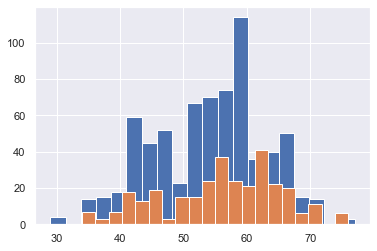

In [6]:
data[data.sex==1].age.hist(bins=20);
data[data.sex==0].age.hist(bins=20);

male/female age distribution in sample is equal, but different in count. It can be important.

In [7]:
print('mens in sample -  {:.2%}'.format(data[data.sex==1].shape[0]/data.shape[0]))

mens in sample -  69.56%


From this graphic we can see, that women in this sample sick much more often that men.

Men have disease:  0.42075736325385693
Women have disease:  0.7243589743589743


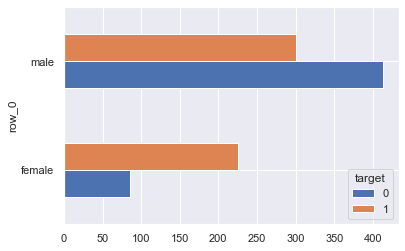

In [8]:
sex_str = np.where(data.sex==1, 'male', 'female')
pd.crosstab(sex_str, data.target).plot(kind='barh');

print("Men have disease: ",data[(data.sex==1)&(data.target==1)].shape[0]/data[(data.sex==1)].shape[0])
print("Women have disease: ",data[(data.sex==0)&(data.target==1)].shape[0]/data[(data.sex==0)].shape[0])

From this countplot we can see, that the danger of the disease is greatly increased from 43 years. But countplot below show that situation isn't bad and a lot if people are healthy in 54-65 years (peak in sample). It mean's that age feature is ambiguous and age don't show certainly probability of getting sick.

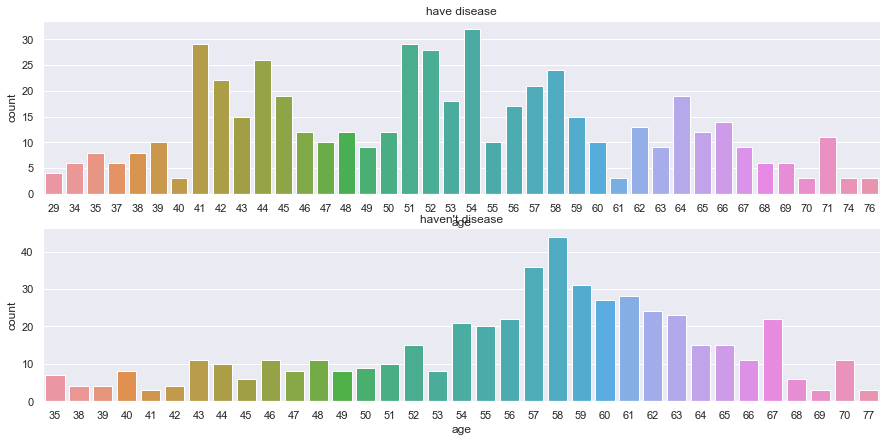

In [9]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('have disease')
ax1.tick_params(labelbottom='off',axis='x')
sns.countplot(data[data.target==1].age);
ax2 = fig.add_subplot(2,1,2)
ax2.set_title("haven't disease")
sns.countplot(data[data.target==0].age);

Here we can see, that chest pain often means that the person is sick. But in about 24% still dangerous situation, when human don't feel pain, but have disease. So, cp feature is relevant.

Human have pain and disease: 76.81%


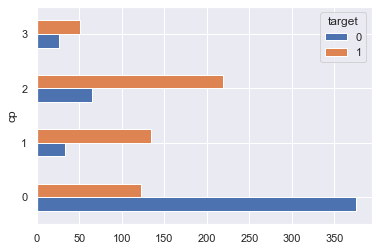

In [10]:
pd.crosstab(data.cp, data.target).plot(kind='barh');
print('Human have pain and disease: {:.4}%'.format(data[(data.target==1) & (data.cp!=0)].shape[0]/data[data.target==1].shape[0]*100))

It seems logical to check how related age and resting blood pressure (trestbps), but corrplot show very weak correlation.

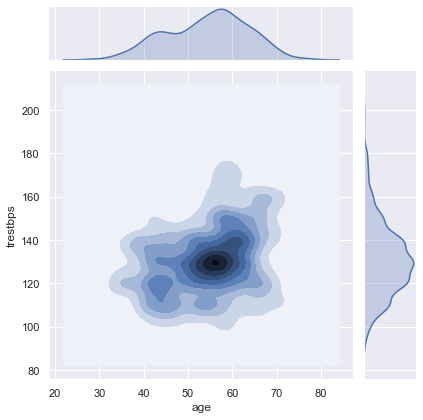

In [11]:
sns.jointplot(data.age, data.trestbps, kind='kde');

Here I cut age to some periods. We see same weak trend to high blood pressure by age, but we can't say anything about relation with blood pressure and taget. Means in disease/not disease slightly different, but IQR(Q3-Q1) doesnt support this assumption. 

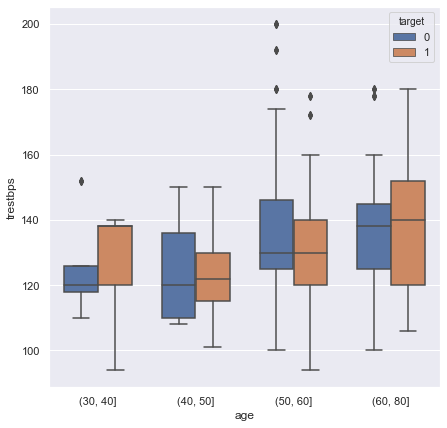

In [12]:
categ = pd.cut(data.age,[30,40,50,60,80])
dat_new = data[['target','trestbps']]
dat_new['age'] = categ
plt.figure(figsize=(7,7))
sns.boxplot(x='age',y='trestbps',hue='target',data=dat_new, width=0.7);

Remember the Sympson paradox, consider the main graphic with target/trestbps, and if show the same picture. So, feature trestbps is the first candidate to delete in feature list.

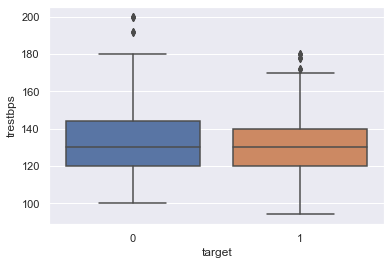

In [13]:
sns.boxplot(x=data.target, y=data.trestbps);

Cholesterol histogramm seems like normal distribution (with some emissions). By ttest we can see, that means are equal, that bad for predictive ability of this feature to the target value.

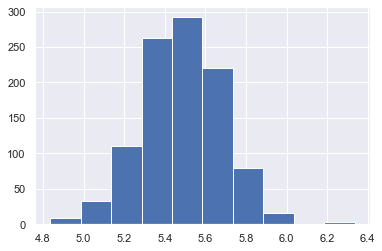

In [14]:
np.log(data.chol).hist();

Ttest_indResult(statistic=3.2134330971791747, pvalue=0.0013525712504626976)

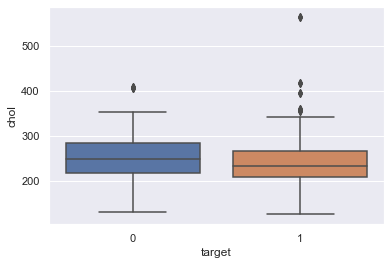

In [15]:
sns.boxplot(x=data.target, y=data.chol);
fst = data[data.target==0].chol
scd = data[data.target==1].chol
stt.ttest_ind_from_stats(fst.mean(),fst.std(),fst.shape[0],\
                         scd.mean(),scd.std(),scd.shape[0],equal_var=True)

Now consider corrplot with all metrical data. This corrplot can't show any high relation.

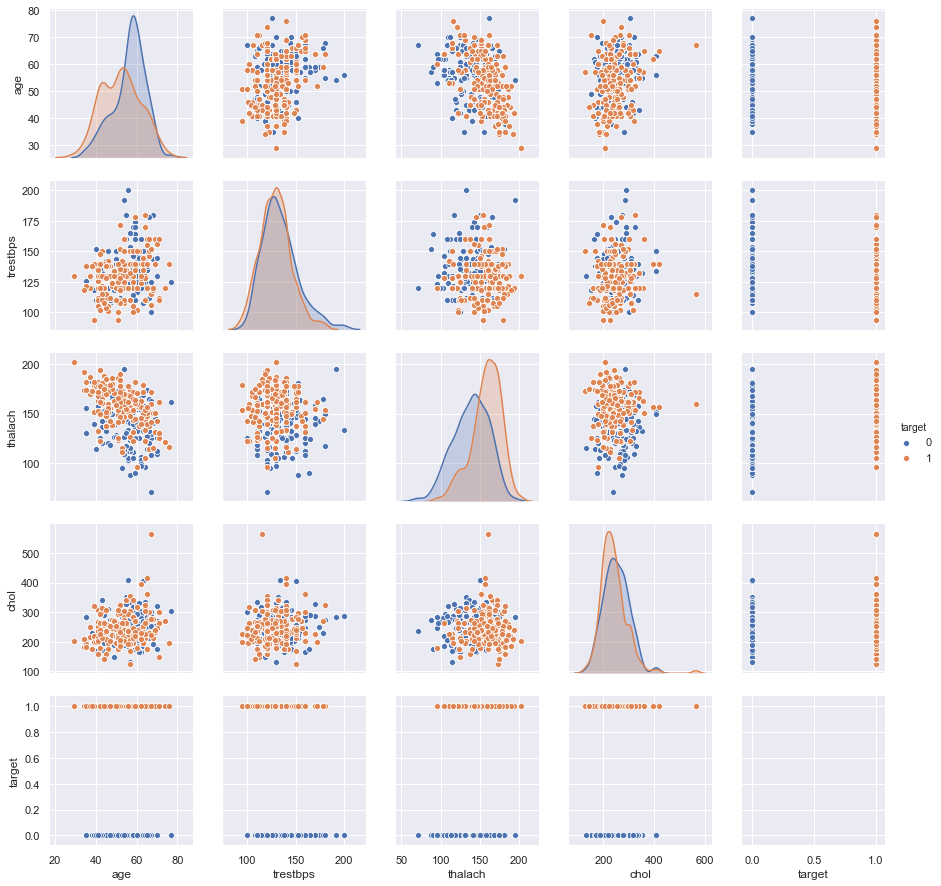

In [16]:
sns.pairplot(data[['age','trestbps','thalach','chol','target']],hue='target',size=2.5);

See to the fbs-feature. This crosstab show that when fasting blood sugar < 120, probability of disease is higher. But this relation isn't high.

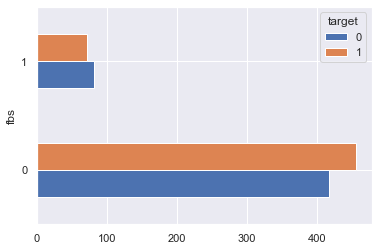

In [17]:
pd.crosstab(data.fbs,data.target).plot(kind='barh');

And the thalach-feature show high differences in disease/not disease. This feature can be relevant. 
Finally, compare all metric data in boxplots. Best features are thalach, age and oldpeak.

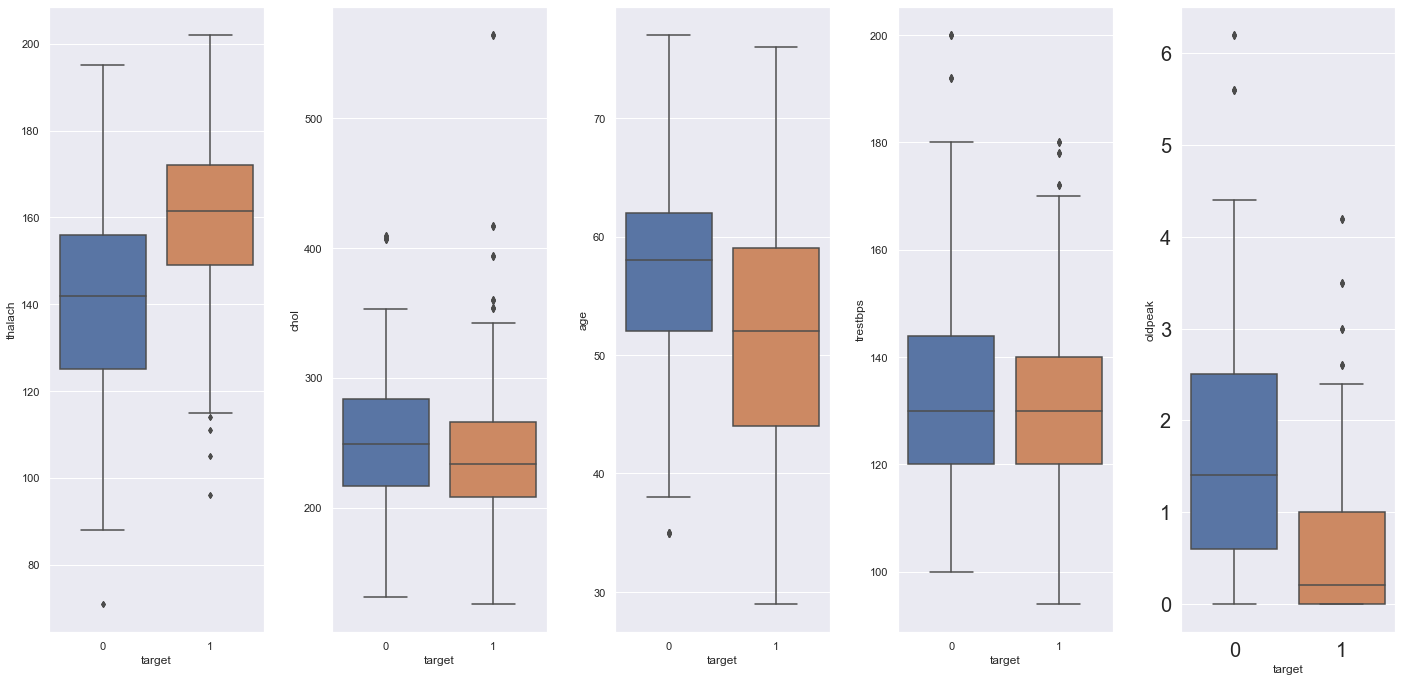

In [18]:
f, axes = plt.subplots(1, 5,figsize=(20,10))
sns.set(font_scale=2)
sns.boxplot(x=data.target, y=data.thalach, ax=axes[0],fliersize=4);
sns.boxplot(x=data.target, y=data.chol, ax=axes[1]);
sns.boxplot(x=data.target, y=data.age, ax=axes[2]);
sns.boxplot(x=data.target, y=data.trestbps, ax=axes[3]);
sns.boxplot(x=data.target, y=data.oldpeak, ax=axes[4]);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

Consider last cathegorical features. They are important and show relations with target.

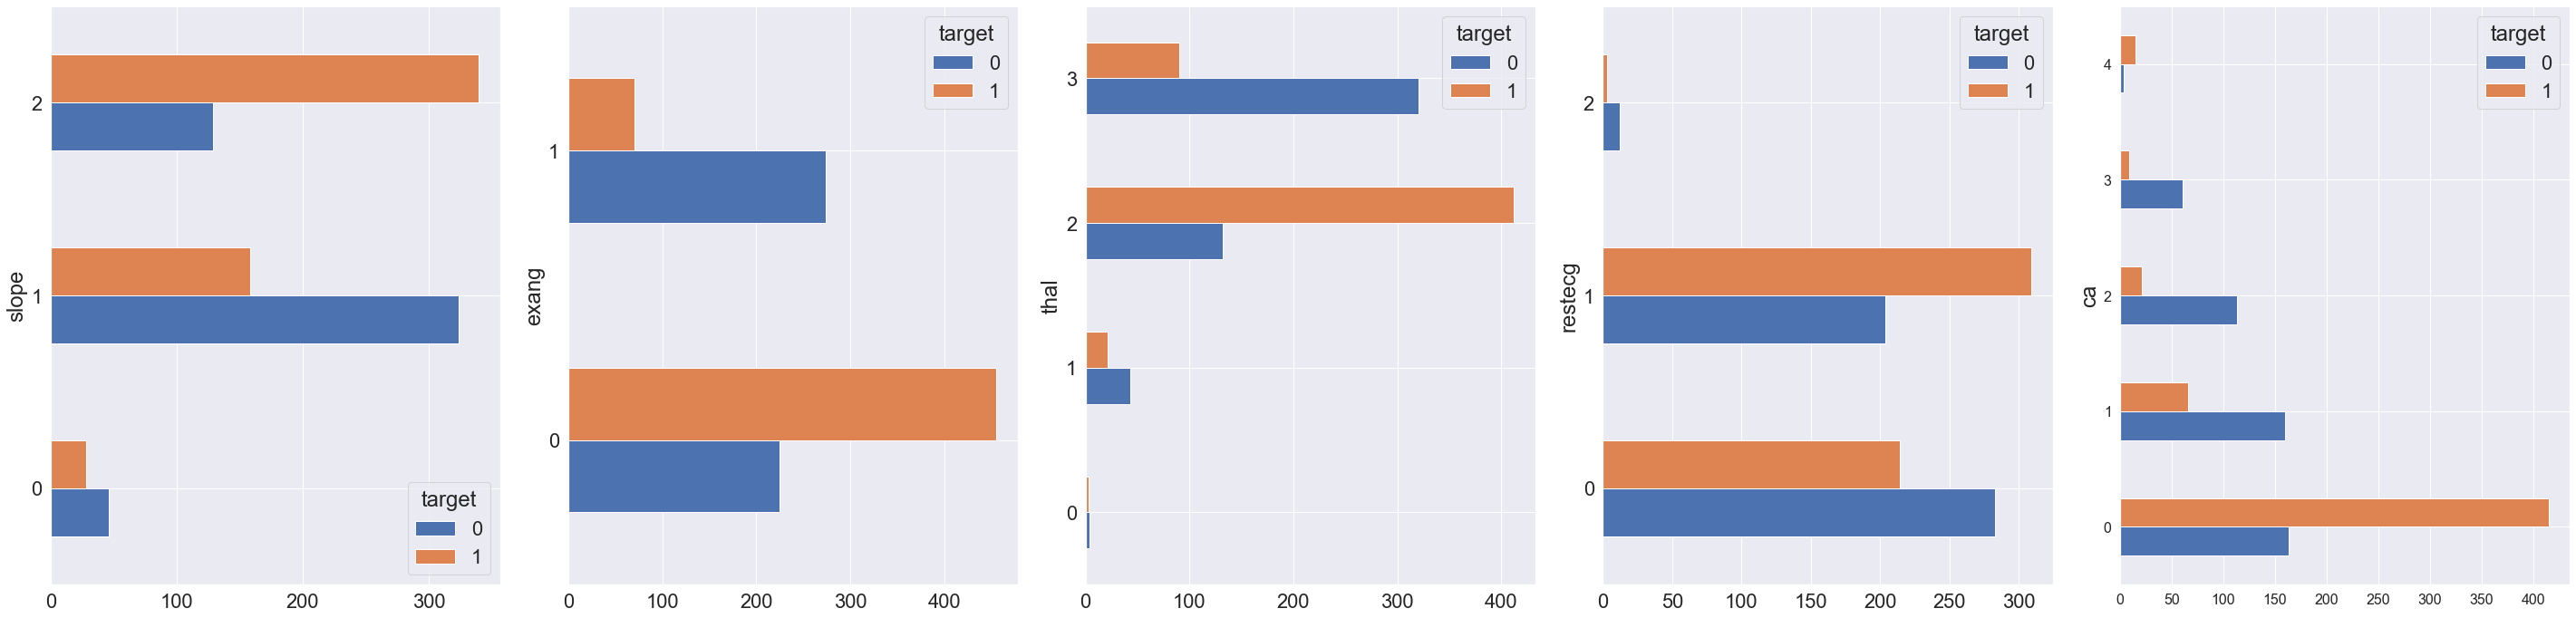

In [19]:
f, axes = plt.subplots(1, 5,figsize=(40,10))
sns.set(font_scale=2)
pd.crosstab(data.slope,data.target).plot(kind='barh', ax=axes[0]);
pd.crosstab(data.exang,data.target).plot(kind='barh', ax=axes[1]);
pd.crosstab(data.thal,data.target).plot(kind='barh', ax=axes[2]);
pd.crosstab(data.restecg,data.target).plot(kind='barh', ax=axes[3]);
pd.crosstab(data.ca,data.target).plot(kind='barh', ax=axes[4]);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

Crosstab with sex and (slope/thal/exang) show that they are related. It's nean that together with sex this features can work better. 

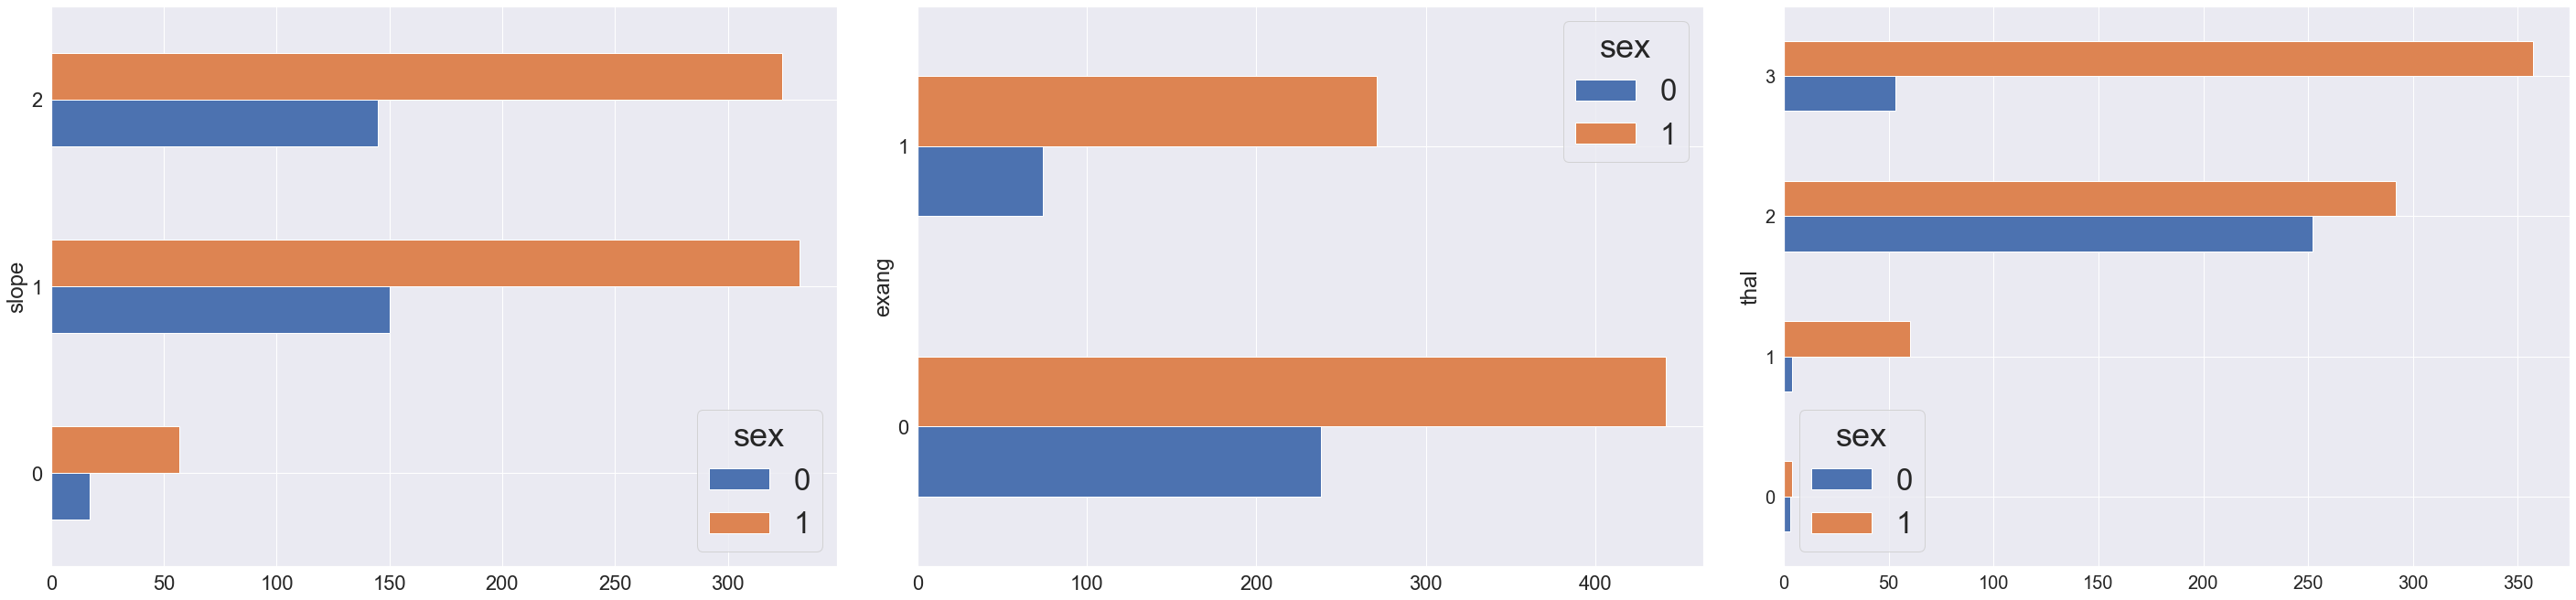

In [20]:
f, axes = plt.subplots(1, 3,figsize=(40,10))
sns.set(font_scale=3)
pd.crosstab(data.slope,data.sex).plot(kind='barh', ax=axes[0]);
pd.crosstab(data.exang,data.sex).plot(kind='barh', ax=axes[1]);
pd.crosstab(data.thal,data.sex).plot(kind='barh', ax=axes[2]);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

Classes are just about the same:

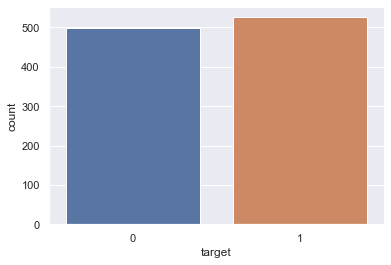

In [21]:
sns.set(font_scale=1)
sns.countplot(data.target);

Finally age, sex, cp, thalach, exang, oldpeak, slope, ca and thal are kept. 

In [22]:
attbs = ['age','sex','cp','thalach','exang','oldpeak','slope','ca','thal']

In [23]:
data_train, data_test, targ_train, targ_test = train_test_split(\
            data[attbs], data.target, test_size=0.2)

In [24]:
data_train

age  sex  cp  thalach  exang  oldpeak  slope  ca  thal
501   35    0   0      182      0      1.4      2   0     2
816   70    1   1      143      0      0.0      2   0     2
649   45    0   1      175      0      0.6      1   0     2
571   60    1   0      142      1      2.8      1   2     3
32    57    1   0      115      1      1.2      1   1     3
..   ...  ...  ..      ...    ...      ...    ...  ..   ...
741   41    0   2      172      1      0.0      2   0     2
31    50    0   1      162      0      1.1      2   0     2
650   62    1   0       99      1      1.8      1   2     3
567   41    1   2      168      0      2.0      1   0     2
511   43    1   0      120      1      2.5      1   0     3

[820 rows x 9 columns]

In [25]:
forest = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4)
forest.fit(data_train, targ_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
labels = forest.predict(data_test)
sns.set(font_scale=1.5)
auc = roc_auc_score(labels, targ_test)
fpr, tpr, thresholds = roc_curve(labels,targ_test)
print('ROC curve: AUC={0:0.2f}'.format(auc));

ROC curve: AUC=0.91


In [27]:
forest.score(data_test,targ_test)

0.9073170731707317

In [28]:
from sklearn import metrics
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(targ_test, labels))
print('Confusion Matrix\n',confusion_matrix(targ_test, labels))
print("Accuracy:",metrics.accuracy_score(targ_test, labels))

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        93
           1       0.88      0.96      0.92       112

    accuracy                           0.91       205
   macro avg       0.91      0.90      0.91       205
weighted avg       0.91      0.91      0.91       205

Confusion Matrix
 [[ 79  14]
 [  5 107]]
Accuracy: 0.9073170731707317


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_train = pd.DataFrame(scaler.fit_transform(data_train), columns = data_train.columns)

In [30]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(data_train)
explained_variance_ratio = pca.explained_variance_ratio_

In [31]:
explained_variance_ratio

array([0.29833116, 0.1379131 , 0.12051158, 0.1133536 , 0.09093797,
       0.08319193, 0.06096645, 0.05200498, 0.04278923])

In [32]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.95) + 1

In [33]:
dim

8

In [34]:
data_train, data_test, targ_train, targ_test = train_test_split(\
            data[attbs[:dim]], data.target, test_size=0.2)

In [35]:
forest = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4)
forest.fit(data_train, targ_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
labels = forest.predict(data_test)
sns.set(font_scale=1.5)
auc = roc_auc_score(labels, targ_test)
fpr, tpr, thresholds = roc_curve(labels,targ_test)
print('ROC curve: AUC={0:0.2f}'.format(auc));

ROC curve: AUC=0.89


In [37]:
forest.score(data_test,targ_test)

0.8682926829268293

In [38]:
print('Classification Report\n',classification_report(targ_test, labels))
print('Confusion Matrix\n',confusion_matrix(targ_test, labels))
print("Accuracy:",metrics.accuracy_score(targ_test, labels))

Classification Report
               precision    recall  f1-score   support

           0       0.95      0.75      0.84        93
           1       0.82      0.96      0.89       112

    accuracy                           0.87       205
   macro avg       0.89      0.86      0.86       205
weighted avg       0.88      0.87      0.87       205

Confusion Matrix
 [[ 70  23]
 [  4 108]]
Accuracy: 0.8682926829268293


Dataset is small, so we can apply cross validation. And this score doesn't show big deviations from our prediction.

In [41]:
scores = cross_val_score(forest, data[attbs[:dim]], data.target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.06)


In [42]:
print(classification_report(labels,targ_test))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        74
           1       0.96      0.82      0.89       131

    accuracy                           0.87       205
   macro avg       0.86      0.89      0.86       205
weighted avg       0.89      0.87      0.87       205

